In [1]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
import torch
labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)","z (mm)",r"$p_z$ (mrad)"]

tkwargs = {"dtype": torch.float}
save_dir = "mse_scale_1_run3_cov_term"
quad_strengths, image_data, bins, xx = load_data(tkwargs)
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 1000000
ensemble[0].beam.set_base_beam(
    ensemble[0].beam.base_dist,
    n_particles,
    p0c=torch.tensor(63.0e6)
)

ensemble.cuda();

C:\ProgramData\Miniconda3\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


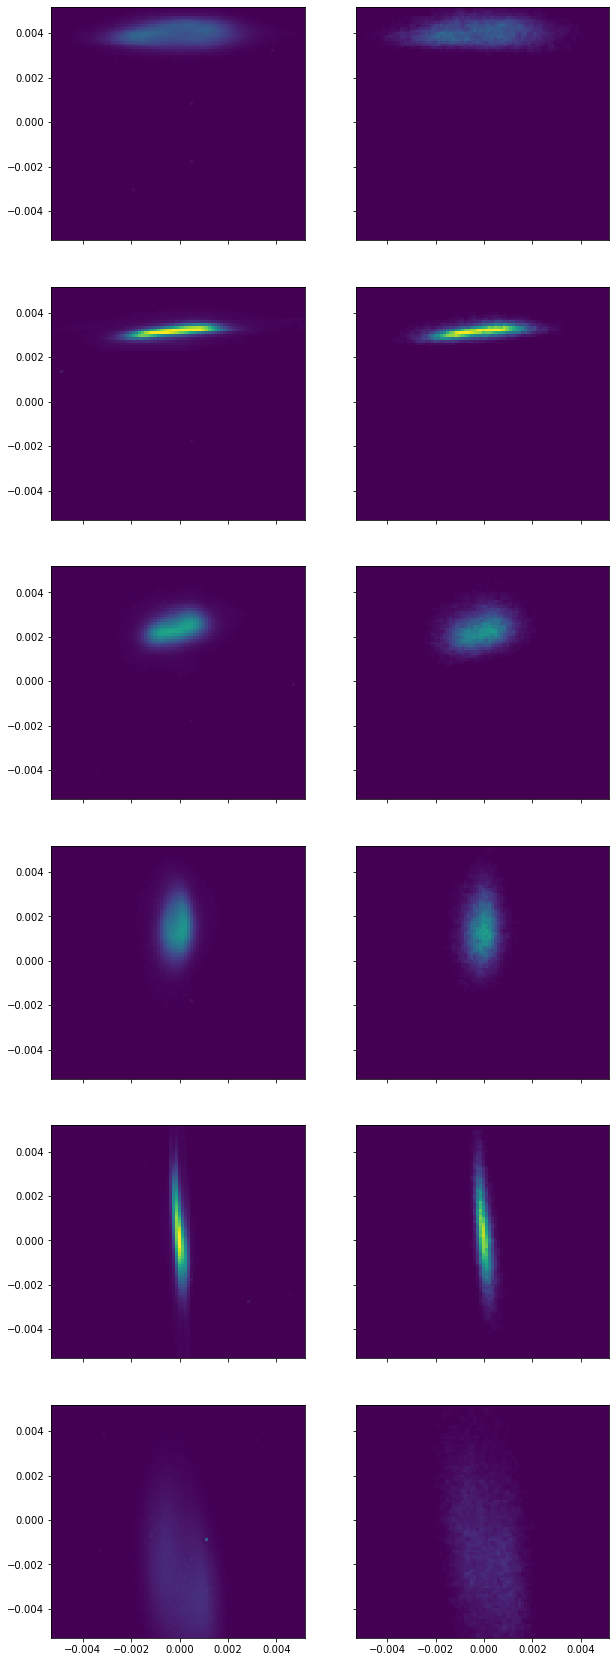

In [2]:
s = torch.arange(0,11,2)
with torch.no_grad():
    predictions, entropy, cov = ensemble[-1](train_dset[s][0].cuda())

fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(s)):
    ax[i][0].pcolor(*xx, train_dset[s[i]][1][0].cpu().detach(),
                    vmin=0,vmax=0.01
                    )
    ax[i][1].pcolor(*xx,predictions[i][0].cpu().detach(), vmin=0,vmax=0.01)

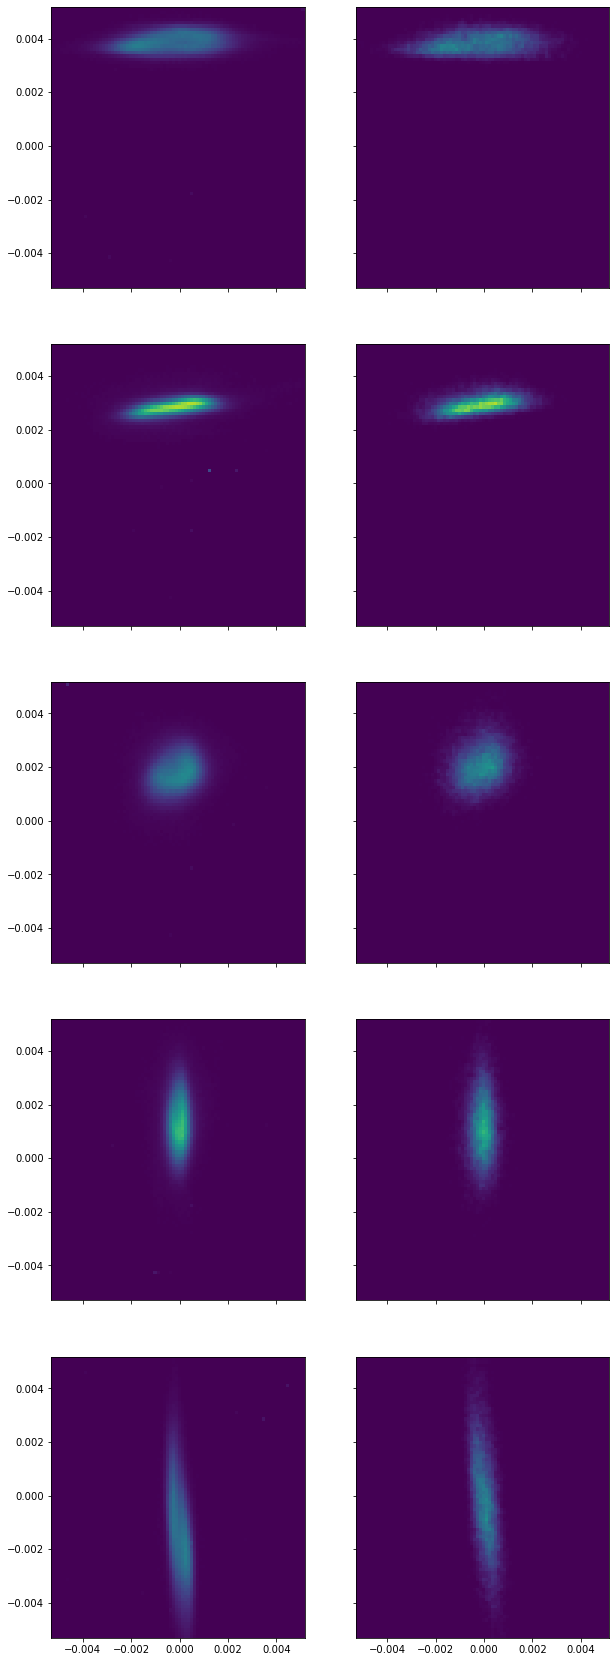

In [3]:
s = torch.arange(0,10,2)
with torch.no_grad():
    predictions, entropy,cov = ensemble[-1](test_dset[s][0].cuda())

fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(s)):
    ax[i][0].pcolor(*xx,test_dset[s[i]][1][0].cpu().detach(),
                    vmin=0,vmax=0.01
                    )
    ax[i][1].pcolor(*xx,predictions[i][0].cpu().detach(), vmin=0,vmax=0.01)


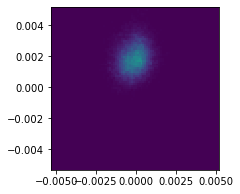

In [4]:
# zero quad strength
with torch.no_grad():
    predictions, entropy, cov = ensemble[-1](torch.zeros(1,1).cuda())

fig,ax = plt.subplots()
fig.set_size_inches(3,3)
ax.pcolor(*xx,predictions[0].cpu().detach(), vmin=0,vmax=0.01)


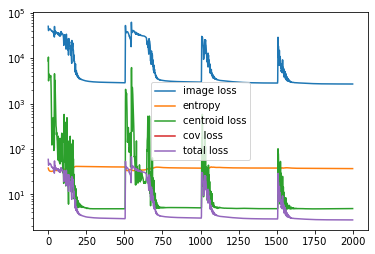

In [5]:
# plot loss record
traces = torch.load(save_dir + "/loss_log.pt")
losses = torch.stack([ele[0] for ele in traces])
covs = torch.stack([ele[1] for ele in traces])

plt.semilogy(
    losses, label=["image loss","entropy","centroid loss","cov loss","total loss"]
)
plt.legend()

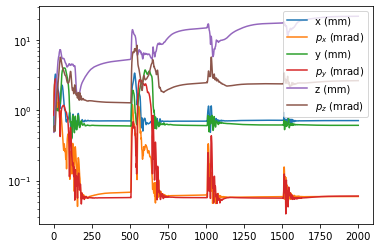

In [6]:
# plot convergence
moments = torch.diagonal(covs, dim1=-2,dim2=-1).sqrt()

plt.semilogy(moments.cpu().detach()*1e3,label=labels)
plt.legend()

In [7]:
initial_beam = ensemble[-1].beam()

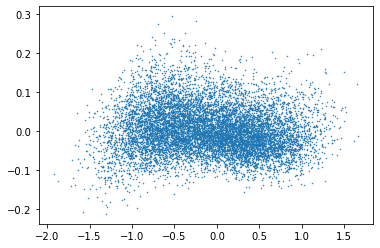

In [8]:
# propagate particles w/quad off
initial_y = initial_beam.y.cpu().detach().numpy()*1e3
initial_py = initial_beam.py.cpu().detach().numpy()*1e3

# distances
dist_to_slits = 3.38 - 2.84 + 0.12/2.0
dist_to_screen = 3.38 + 0.12/2.0

# particles
slits_y = initial_y + initial_py * dist_to_slits
slits_py = initial_py

screen_y = initial_y + initial_py * dist_to_screen
screen_py = initial_py

fig,ax=plt.subplots()
ax.plot(
    initial_y,
    initial_py,
    '.',ms=1
)

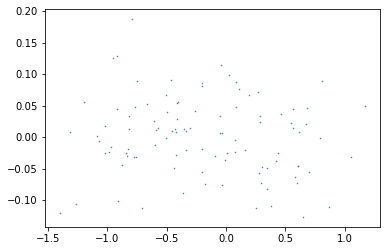

In [9]:
fig,ax=plt.subplots()
ax.plot(
    slits_y[::100], slits_py[::100],
    '.',ms=1
)

Text(0.5, 0, '$y$ (mm)')

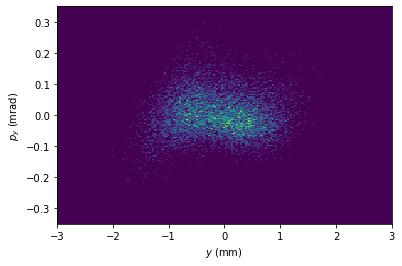

In [10]:
fig,ax=plt.subplots()
import numpy as np
# create a mesh
x = np.linspace(-3,3,200)
y = np.linspace(-0.35,0.35,200)

h, xe, ye = np.histogram2d(slits_y, slits_py, bins=[x,y])
#xc = (xe[:-1] + xe[1:]) / 2
#yc = (ye[:-1] + ye[1:]) / 2
X, Y = np.meshgrid(xe,ye)

ax.pcolor(X, Y, h.T)
ax.set_ylabel(r"$p_y$ (mrad)")
ax.set_xlabel(r"$y$ (mm)")

Text(0.5, 0, '$y$ (mm)')

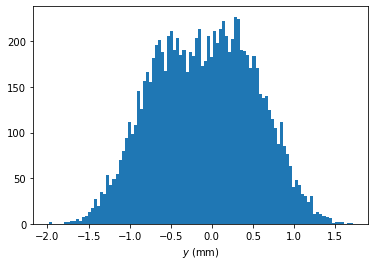

In [11]:
fig,ax=plt.subplots()
ax.hist(
    slits_y, bins=100
);
ax.set_xlabel(r"$y$ (mm)")

Text(0.5, 0, '$yp$ (mrad)')

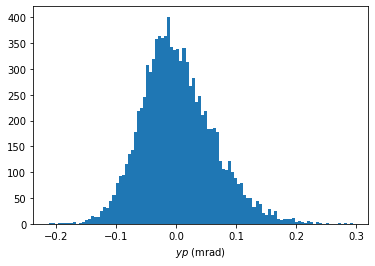

In [12]:
fig,ax=plt.subplots()
ax.hist(
    slits_py, bins=100
);
ax.set_xlabel(r"$yp$ (mrad)")

In [13]:
cov = torch.cov(initial_beam.data.T)
cov

tensor([[ 5.1255e-07,  1.2458e-08,  1.0004e-07, -2.2800e-08, -1.0954e-05,
         -7.5696e-07],
        [ 1.2458e-08,  3.5562e-09,  1.7642e-08, -1.9277e-10, -6.3257e-07,
         -6.6830e-08],
        [ 1.0004e-07,  1.7642e-08,  3.7558e-07, -3.1958e-09, -3.3272e-06,
         -7.0559e-07],
        [-2.2800e-08, -1.9277e-10, -3.1958e-09,  3.6553e-09,  6.9945e-07,
         -4.5904e-08],
        [-1.0954e-05, -6.3257e-07, -3.3272e-06,  6.9945e-07,  4.7597e-04,
         -7.5290e-07],
        [-7.5696e-07, -6.6830e-08, -7.0559e-07, -4.5904e-08, -7.5290e-07,
          7.0095e-06]], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [14]:
ycov = cov[2:4,2:4]

In [15]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(cov, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ellipse

In [16]:
emit = torch.det(ycov).sqrt()
twiss = ycov / emit
print(f"emit {emit}")
print(f"beta {twiss[0,0]}")
print(f"alpha {-twiss[1,0]}")
print(f"gamma {twiss[1,1]}")

emit 3.6913874623678566e-08
beta 10.174517631530762
alpha 0.08657314628362656
gamma 0.09902139008045197


In [17]:
# geometric emittance
print(f"geo_emit: {emit}")
print(f"norm emit: {emit*63.0/0.511}")

geo_emit: 3.6913874623678566e-08
norm emit: 4.551025540422415e-06


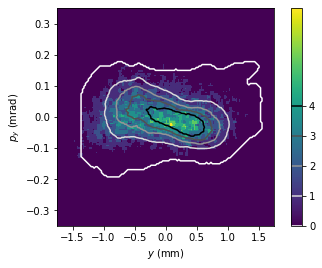

In [18]:
# compare reconstruction to slit scan measurement
import numpy as np
from scipy.ndimage import median_filter

fpath = ""

meas_y = np.load(fpath + "y_recon.npy")*1e3
meas_yp = np.load(fpath + "yp_recon.npy")*1e3

fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
# create a mesh
x1 = np.linspace(-1.75,1.75,150)
x2 = np.linspace(-0.35,0.35,150)

h_reconstruction, xe, ye = np.histogram2d(slits_y, slits_py, bins=[x1,x2], density=True)
h_slitscan, _, _ = np.histogram2d(meas_y, meas_yp, bins=[x1,x2], density=True)

# apply median filter
h_reconstruction = median_filter(h_reconstruction, 3)
h_slitscan = median_filter(h_slitscan,5)

x1c = (xe[:-1] + xe[1:]) / 2
x2c = (ye[:-1] + ye[1:]) / 2

X, Y = np.meshgrid(xe,ye)
Xc, Yc = np.meshgrid(x1c,x2c)

c1 = ax.pcolor(X, Y, h_reconstruction.T)
#ax.contour(Xc, Yc, h_reconstruction.T,levels=3)
clevels = np.arange(0,5)
c2 = ax.contour(Xc, Yc, h_slitscan.T, levels=clevels,cmap="Greys")

cbar = fig.colorbar(c1)
cbar.set_ticks(clevels)
cbar.add_lines(c2)
# add ellipse
#ax.add_patch(confidence_ellipse(ycov.cpu().detach().numpy(),1.0e3,edgecolor='red'))

ax.set_ylabel(r"$p_y$ (mrad)")
ax.set_xlabel(r"$y$ (mm)")
ax.set_aspect(5)
#fig.savefig(f"reconstruction_comparison_{save_dir}.png", dpi=300)

In [19]:
# do core analysis
initial_data = initial_beam.data[:,2:4].cpu()

# sort by distance from origin in 4D phase space
initial_norm = torch.norm(initial_data, dim=-1)
initial_data_sorted = initial_data[torch.argsort(initial_norm),:]


geo_emit: 3.0310264520494457e-08
norm emit: 3.7368820358096855e-06
beta 8.89426040649414
alpha 0.1910782754421234
gamma 0.11653705686330795


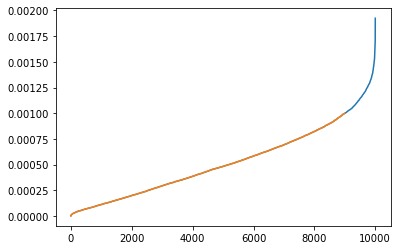

In [20]:
# get cov/emit of 95%
frac = 0.90
partial = initial_data_sorted[:int(initial_data_sorted.shape[0]*frac)]
cov = torch.cov(partial.T)

plt.plot(torch.norm(initial_data_sorted, dim=-1).detach().numpy())
plt.plot(torch.norm(partial, dim=-1).detach().numpy())

emit = torch.det(cov).sqrt()
print(f"geo_emit: {emit}")
print(f"norm emit: {emit*63.0/0.511}")

twiss = cov / emit
print(f"beta {twiss[0,0]}")
print(f"alpha {-twiss[1,0]}")
print(f"gamma {twiss[1,1]}")